In [1]:
import datetime
import os
import time
from pathlib import Path
from typing import Dict, List, Optional, Union
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import utils as vutils
from dataset import EMnistDataset
import struct

gen_img_root = Path("CGAN/images")
weights_root = Path("CGAN/weights")
gen_img_root.mkdir(parents=True, exist_ok=True)
weights_root.mkdir(parents=True, exist_ok=True)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

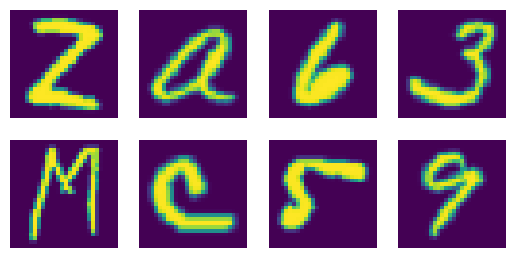

In [2]:
fig, axs = plt.subplots(3, 4)
images = np.load('emnist_img.npy')[:8]
for i, ax in enumerate(axs.flatten()):
    if i < len(images):
        ax.imshow(images[i])
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [3]:
label = np.load('emnist_label.npy')
print(label.shape, label[0:8])

(697932,) [35 36  6  3 22 38  5  9]


In [4]:
datapath = {'img': 'emnist_img.npy',
            'label':"emnist_label.npy"}

In [5]:
classes = [10,11,13,14,15,16,17,23,26,27,29]

In [6]:
class Parse:
    def __init__(self) -> None:
        self.n_epochs = 100
        self.batch_size = 256
        self.lr = 1e-3
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 1
        self.sample_interval = 2000
        self.n_classes = 62


opt = Parse()

In [7]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 3080


In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

img_shape = (opt.channels, opt.img_size, opt.img_size)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [9]:
from torchvision.transforms import InterpolationMode
# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss().to(device)

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
dataloader = DataLoader(
    EMnistDataset(datapath,
                  transform=transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(size=[32,32], interpolation=InterpolationMode.BICUBIC),
                                                transforms.Normalize([0.5], [0.5])]),
                    bonus = False),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# record trianing loss
record: Dict[str, List[float]] = {"D_loss": [], "G_loss": []}

In [10]:
def show_images(real_imgs, fake_imgs: None, nrow=6, ncol=6, figsize=(10, 10), save: bool = False, show: bool = True, name=""):
    # compare and show n*m images from generator in one figure and optionally save it
    for imgs, label in zip([imgs for imgs in [real_imgs, fake_imgs] if fake_imgs is not None], ["real", "fake"]):
        imgs = imgs[:nrow * ncol]
        
        imgs = imgs.view(imgs.size(0), opt.channels, opt.img_size, opt.img_size)
        plt.figure(figsize=figsize)
        plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.axis('off')
        plt.title(name + label + " images")
        if save:
            plt.savefig(gen_img_root / (name + label + " images.png"))
        if show:
            plt.show()


def to_td(second: Union[int, float]) -> str:
    # convert seconds to time delta
    return str(datetime.timedelta(seconds=int(second)))

 E001B001, [0:00:00/1 day, 23:15:37]  0.62s/epoch D_loss: 0.6901 = r0.6850 + f0.6952  G_loss: 0.6901

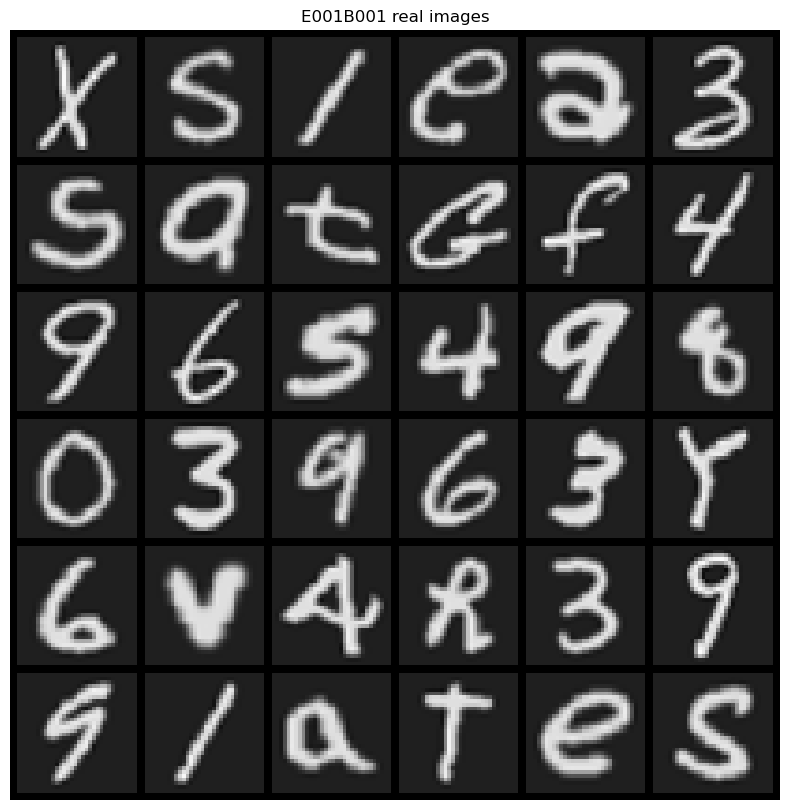

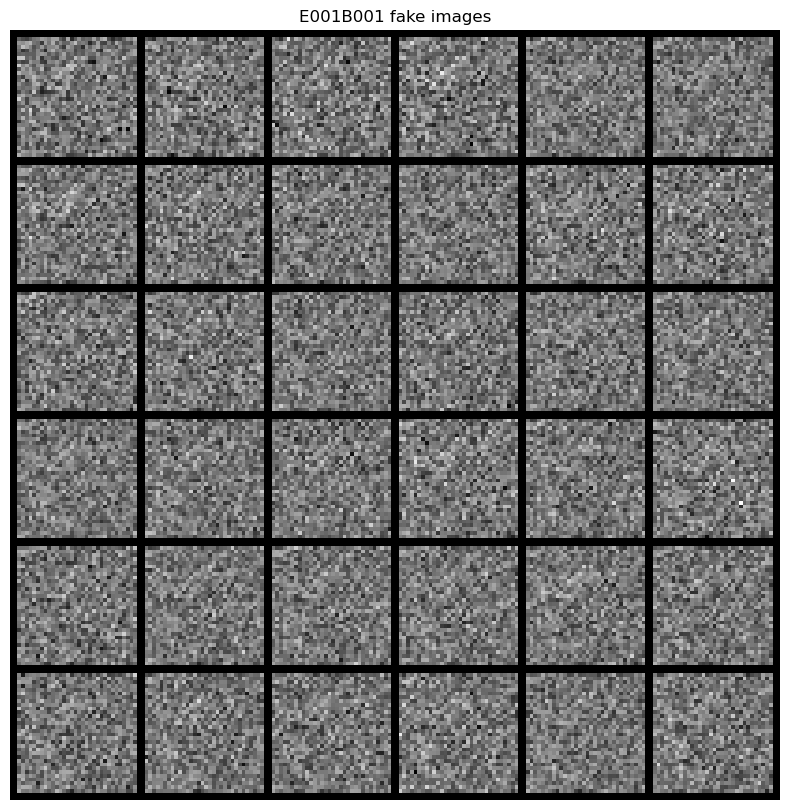

 E001B2710, [0:01:53/3:11:07] 57.17s/epoch D_loss: 0.4074 = r0.7202 + f0.0945  G_loss: 2.8996

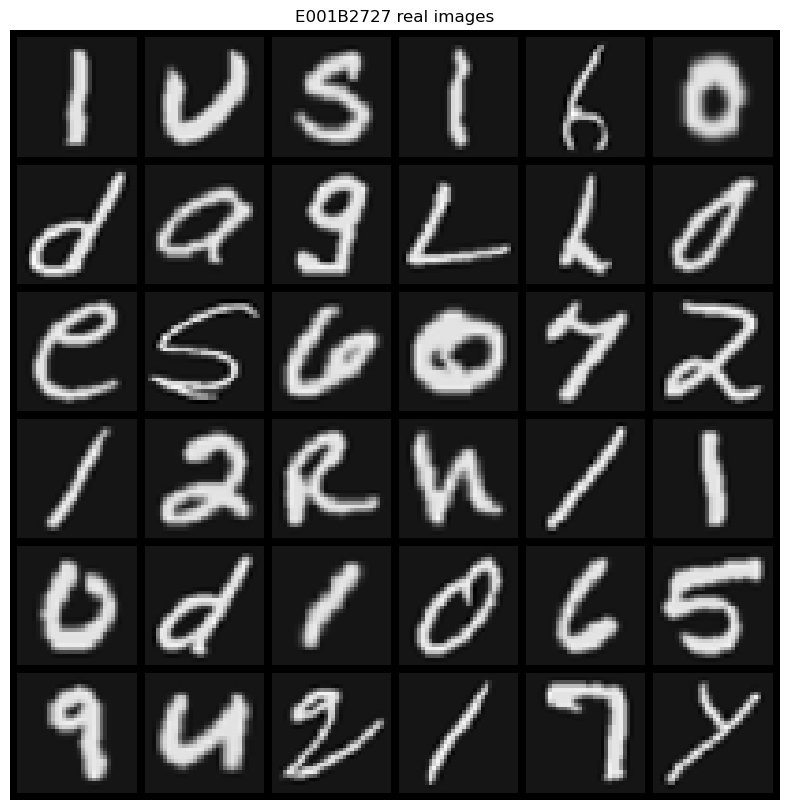

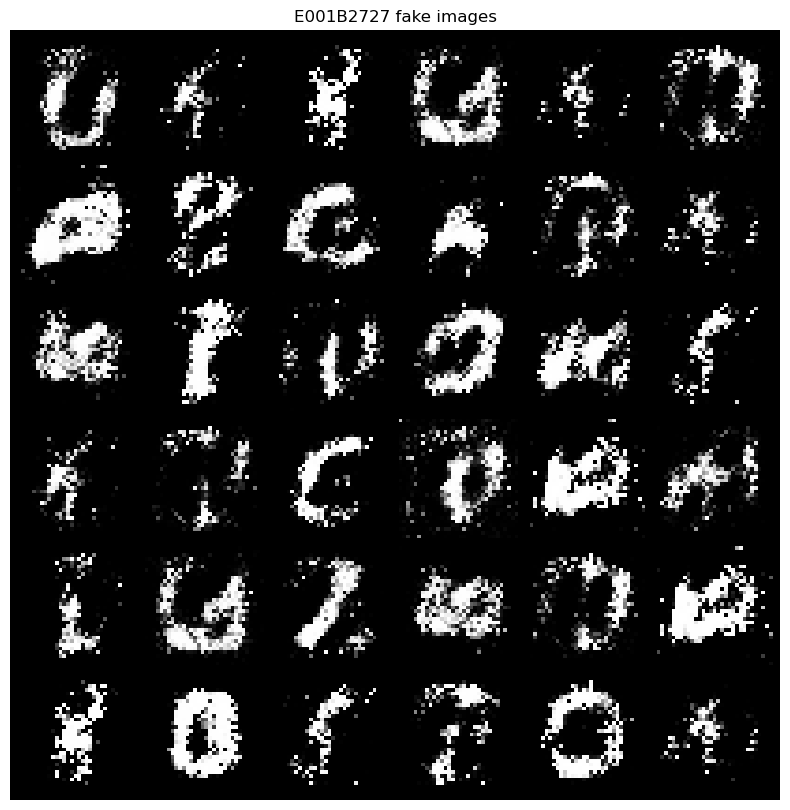

 E010B2716, [0:18:51/3:08:42] 102.94s/epoch D_loss: 0.0996 = r0.0860 + f0.1131  G_loss: 3.92419

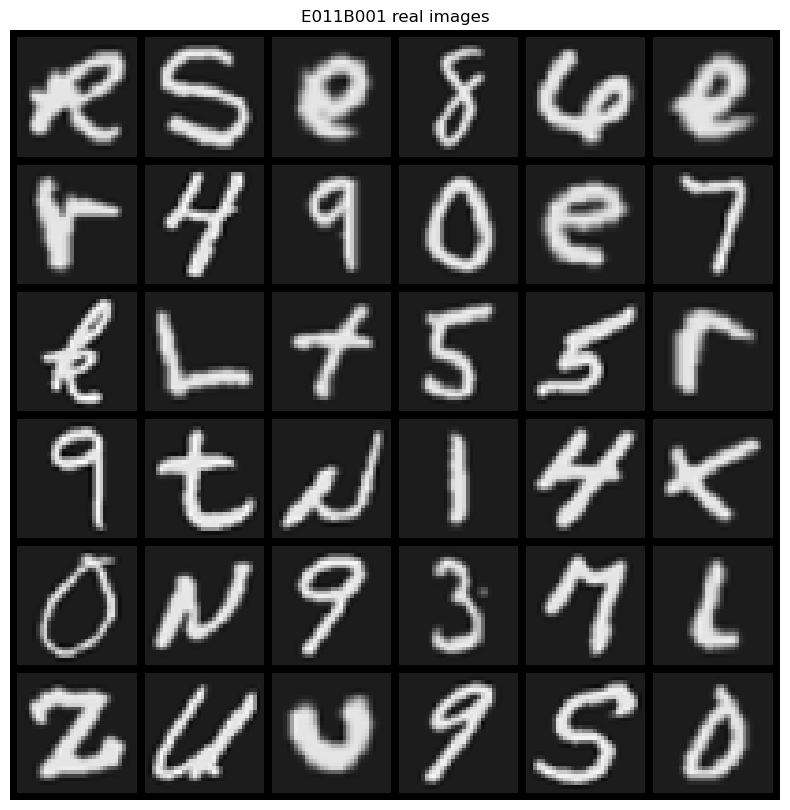

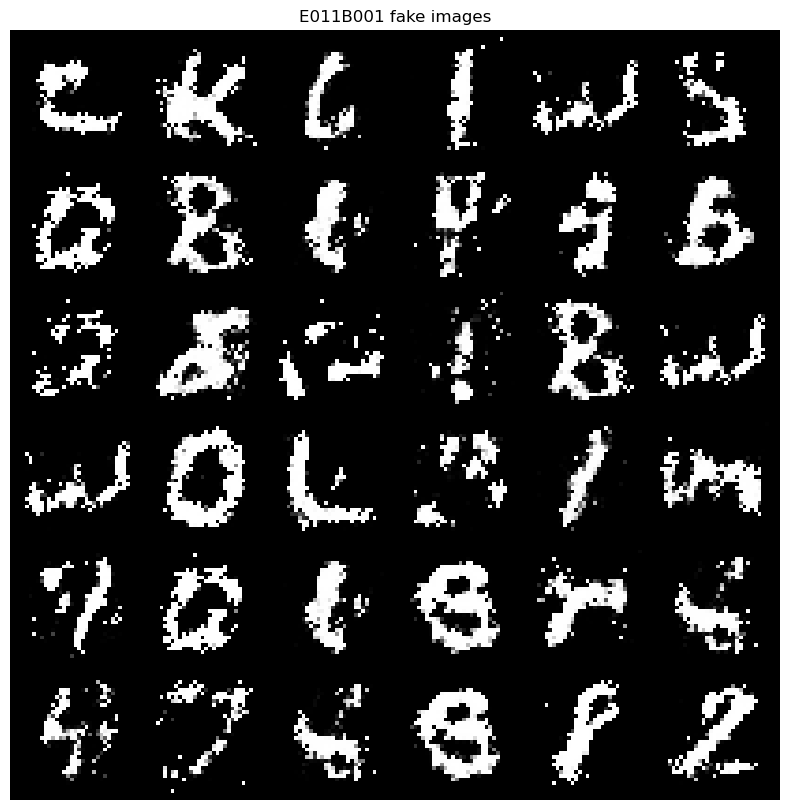

 E011B2719, [0:20:46/3:08:51] 103.87s/epoch D_loss: 0.2924 = r0.5416 + f0.0433  G_loss: 4.2905

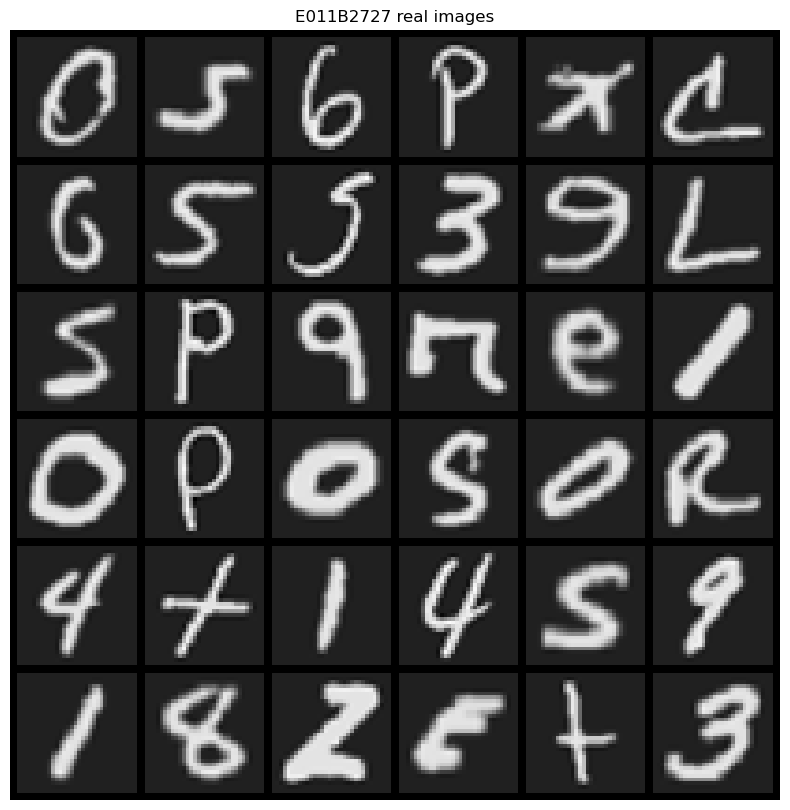

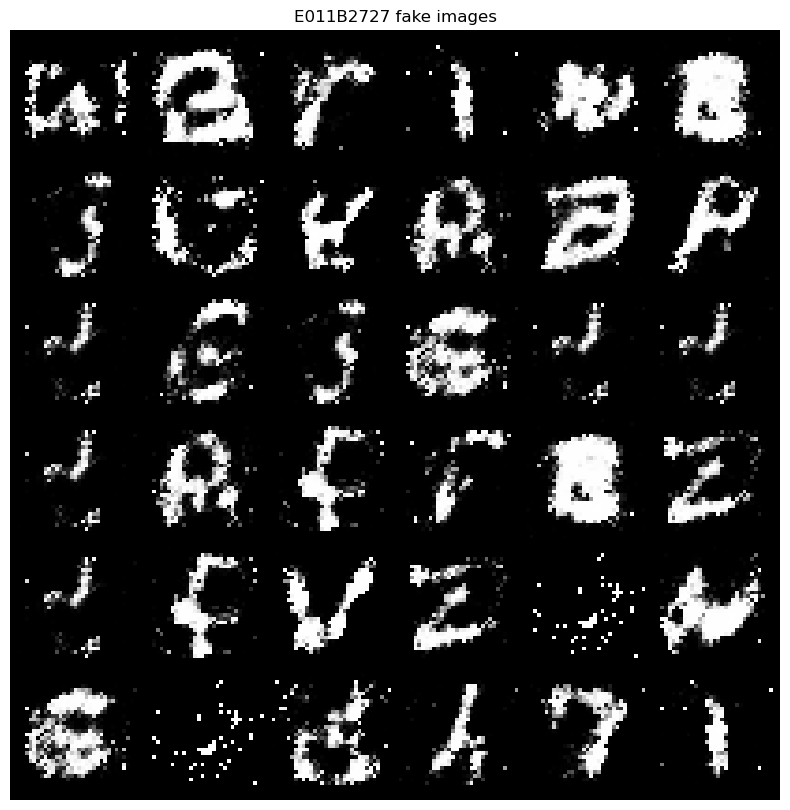

 E020B2725, [0:37:42/3:08:30] 107.72s/epoch D_loss: 0.2008 = r0.1291 + f0.2726  G_loss: 2.3736515

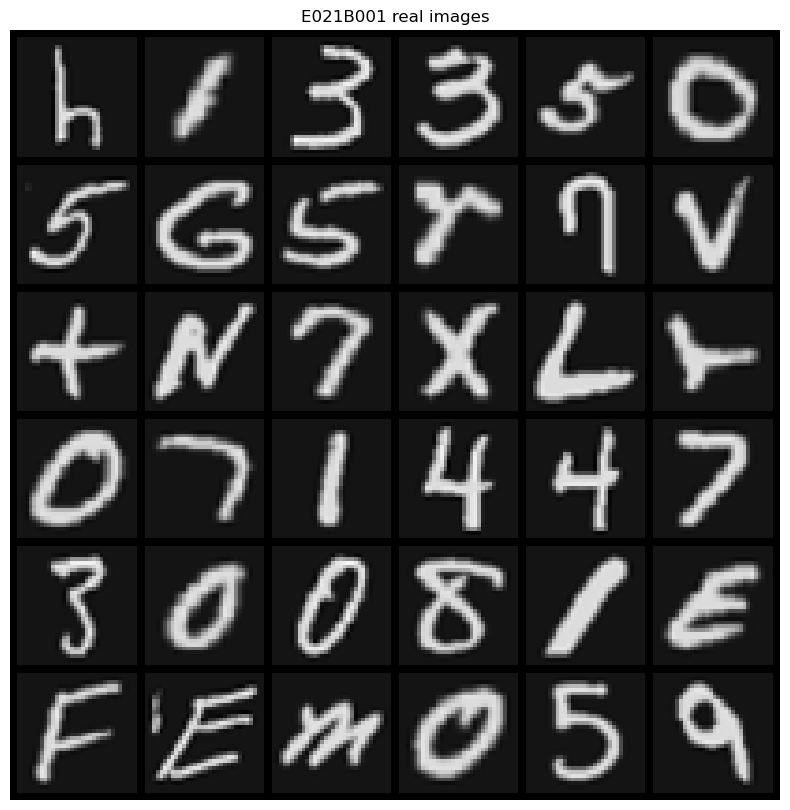

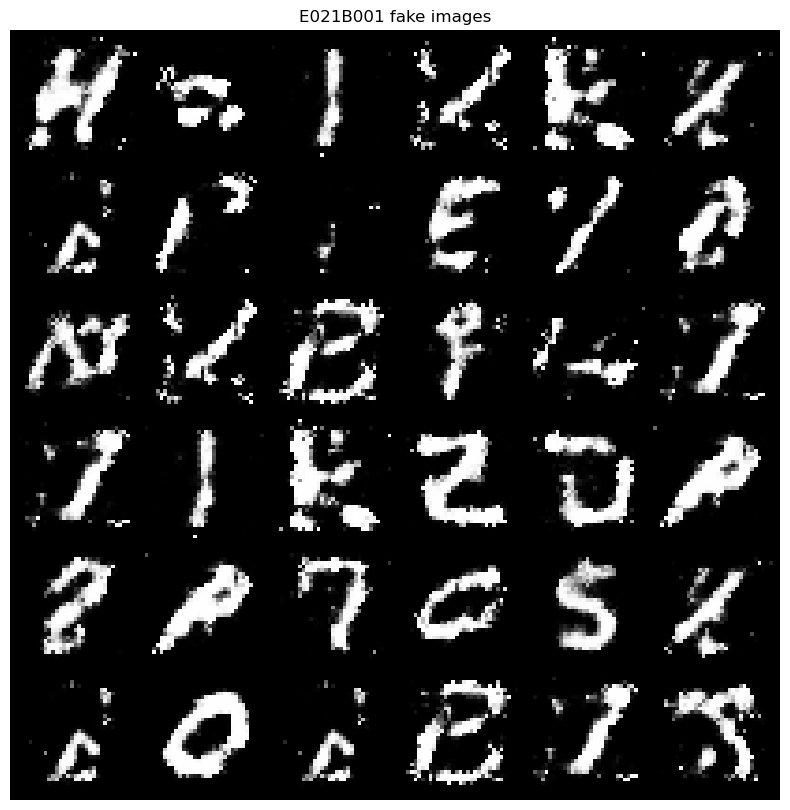

 E021B2707, [0:39:34/3:08:32] 107.98s/epoch D_loss: 0.1870 = r0.2276 + f0.1464  G_loss: 2.9854

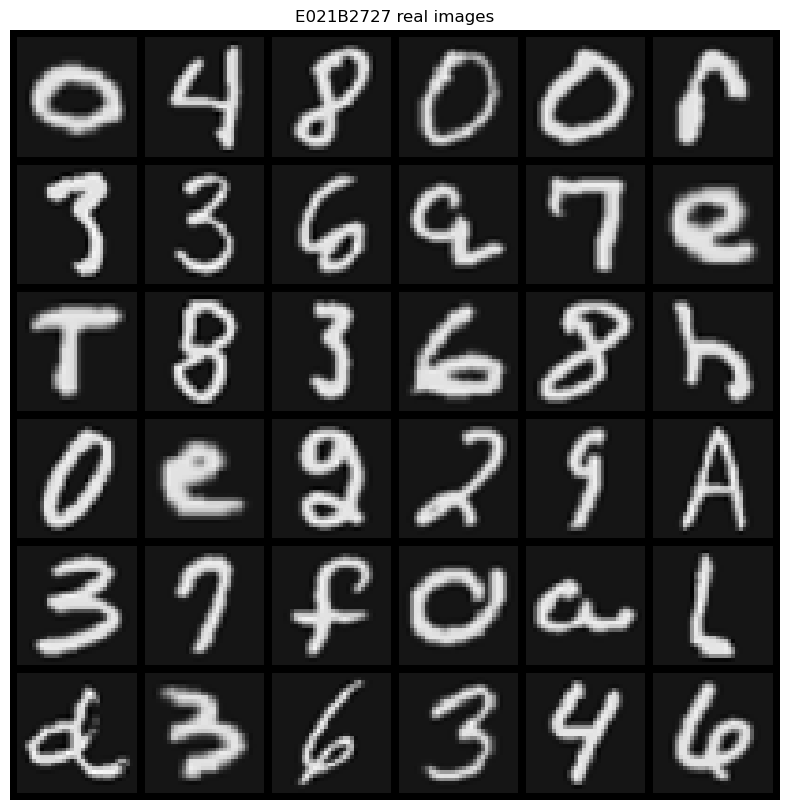

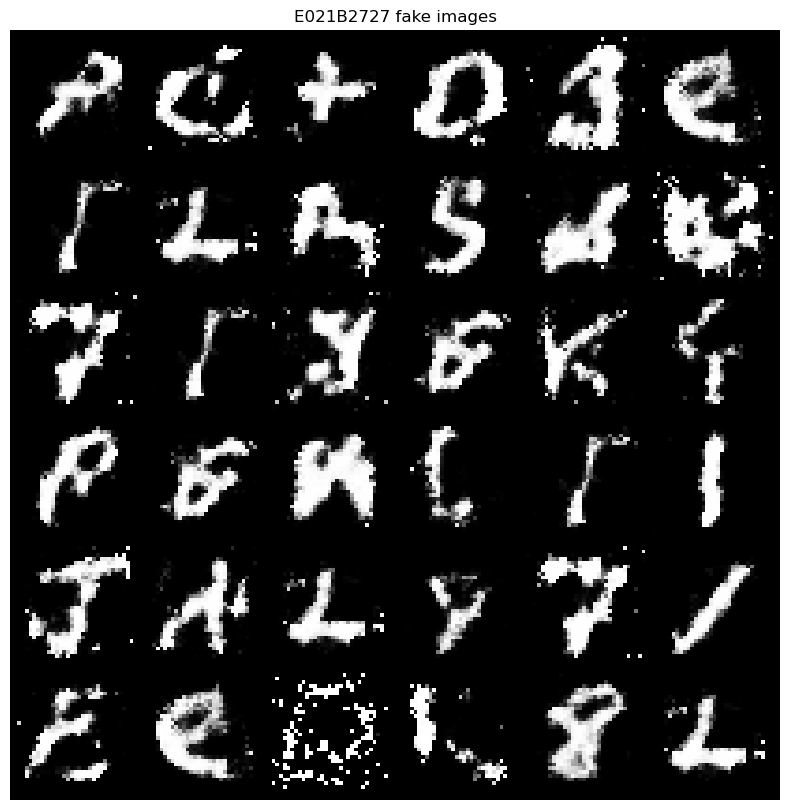

 E030B2713, [0:56:33/3:08:35] 109.50s/epoch D_loss: 0.1592 = r0.1306 + f0.1878  G_loss: 3.2299220

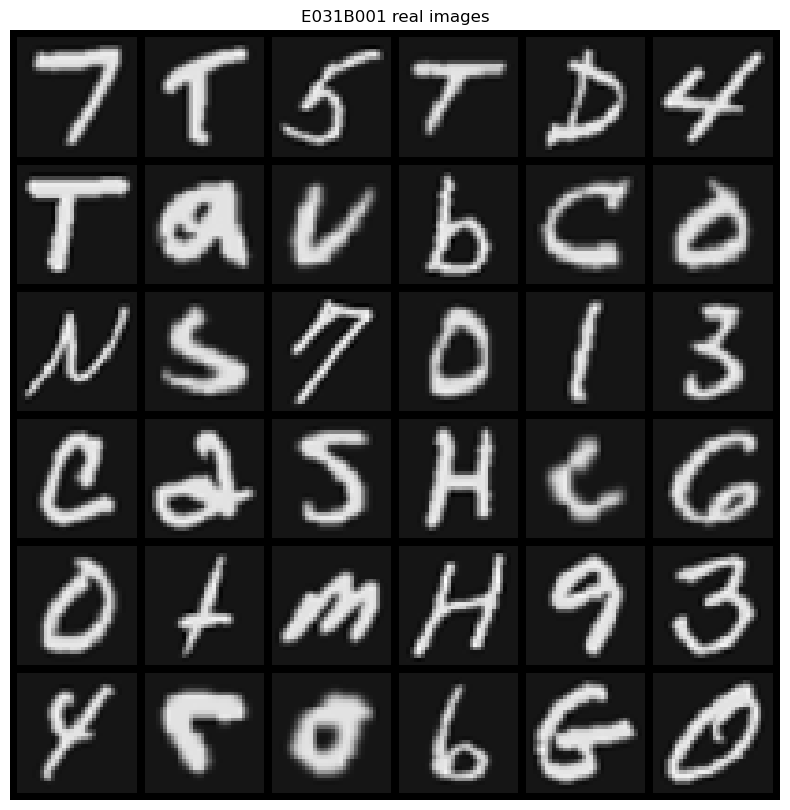

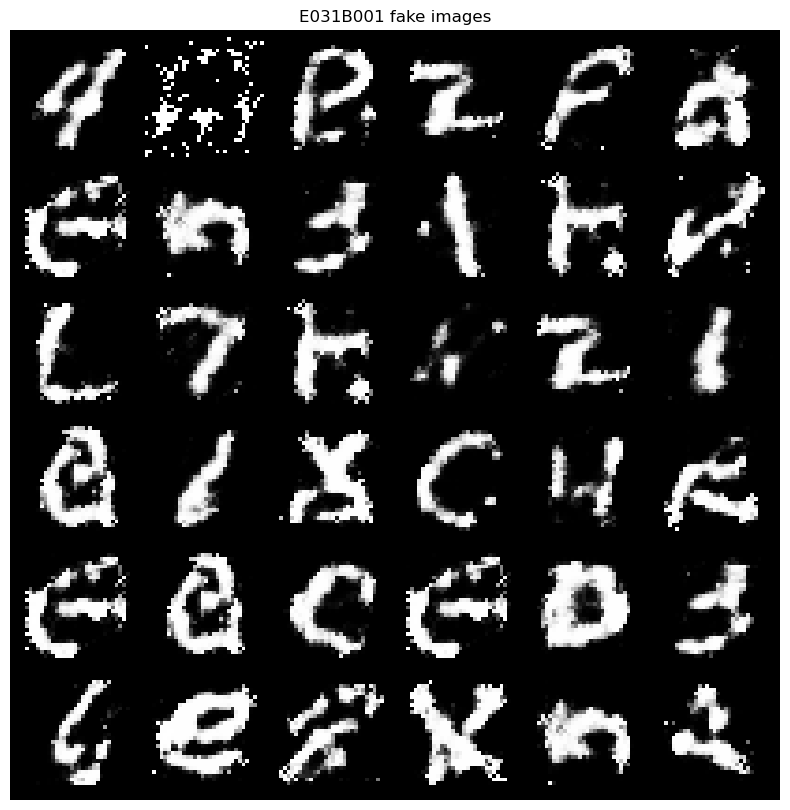

 E031B2716, [0:58:27/3:08:36] 109.63s/epoch D_loss: 0.1183 = r0.1718 + f0.0647  G_loss: 3.58660

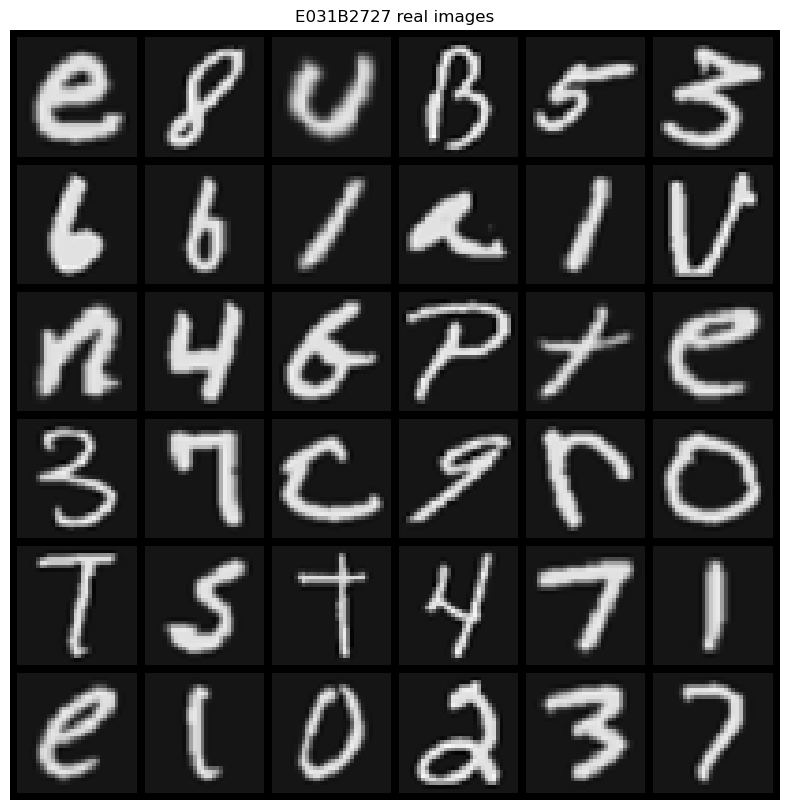

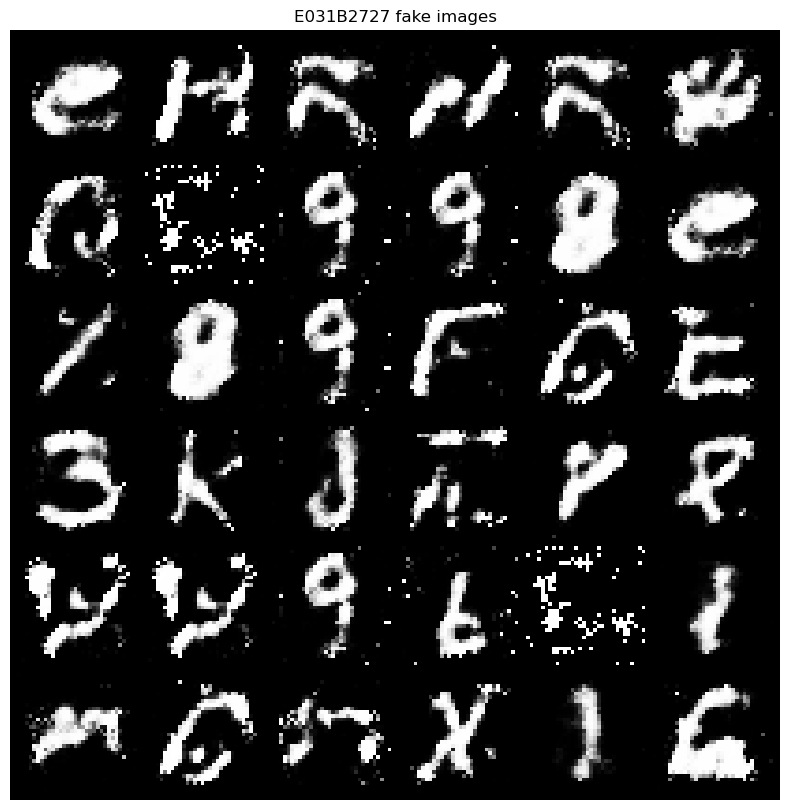

 E040B2722, [1:15:23/3:08:28] 110.33s/epoch D_loss: 0.3319 = r0.6599 + f0.0038  G_loss: 6.527023

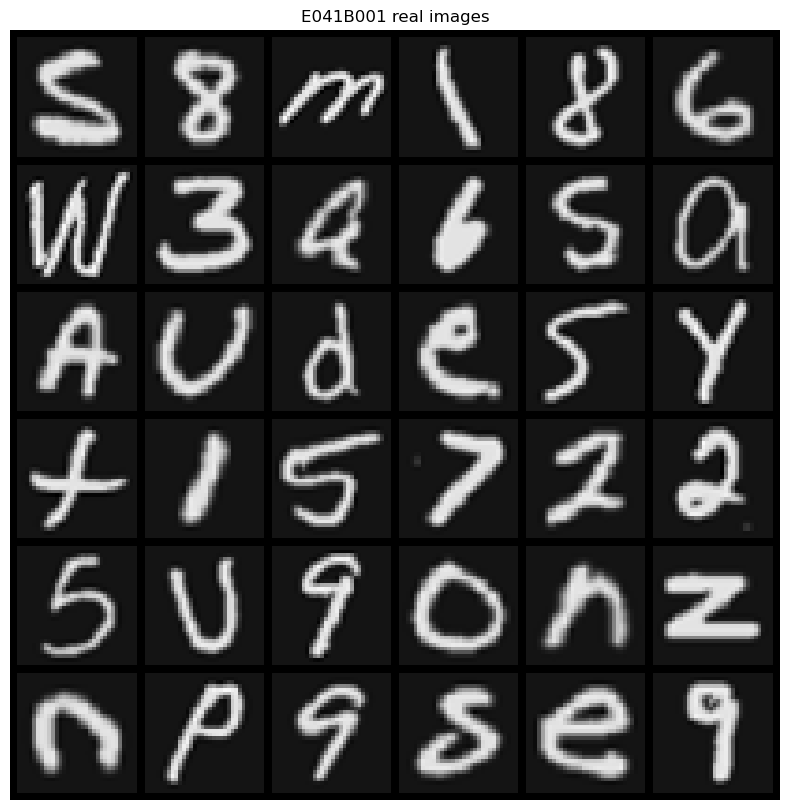

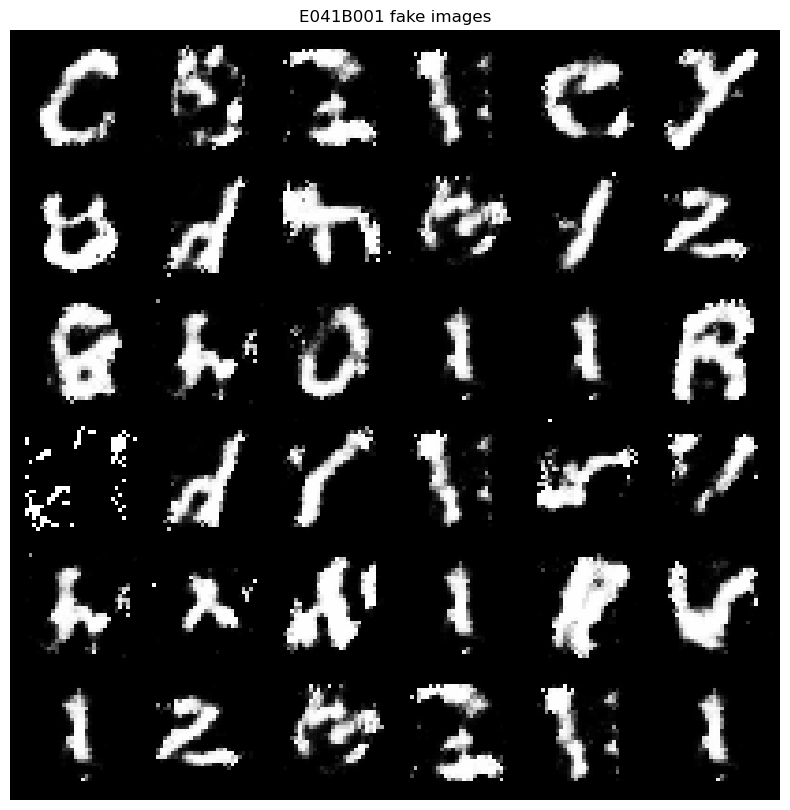

 E041B2725, [1:17:16/3:08:28] 110.39s/epoch D_loss: 1.7638 = r3.5276 + f0.0001  G_loss: 11.0774

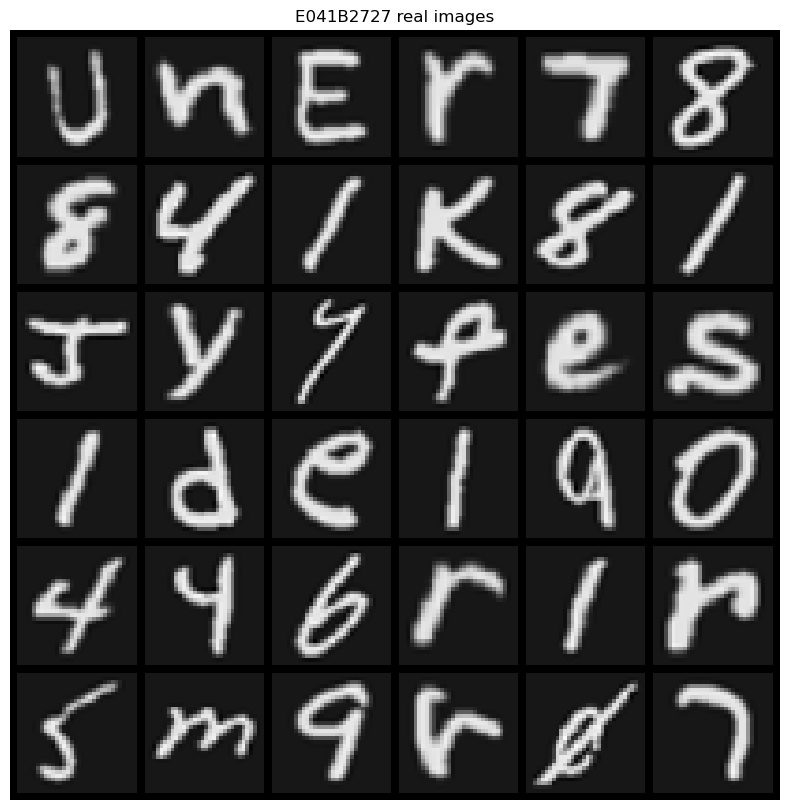

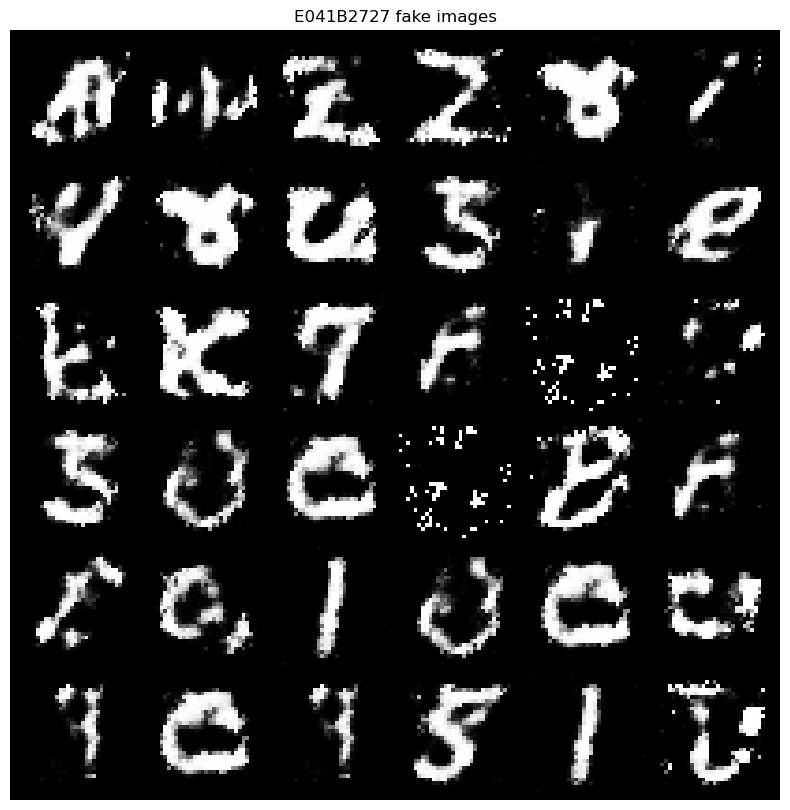

 E050B2710, [1:34:15/3:08:33] 110.91s/epoch D_loss: 0.1496 = r0.0876 + f0.2116  G_loss: 3.68372

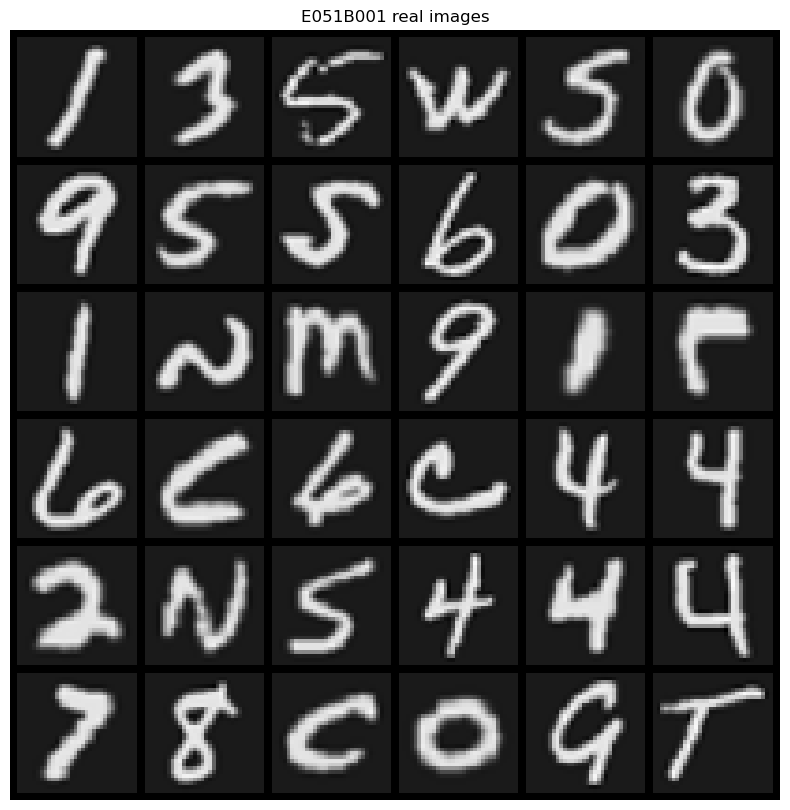

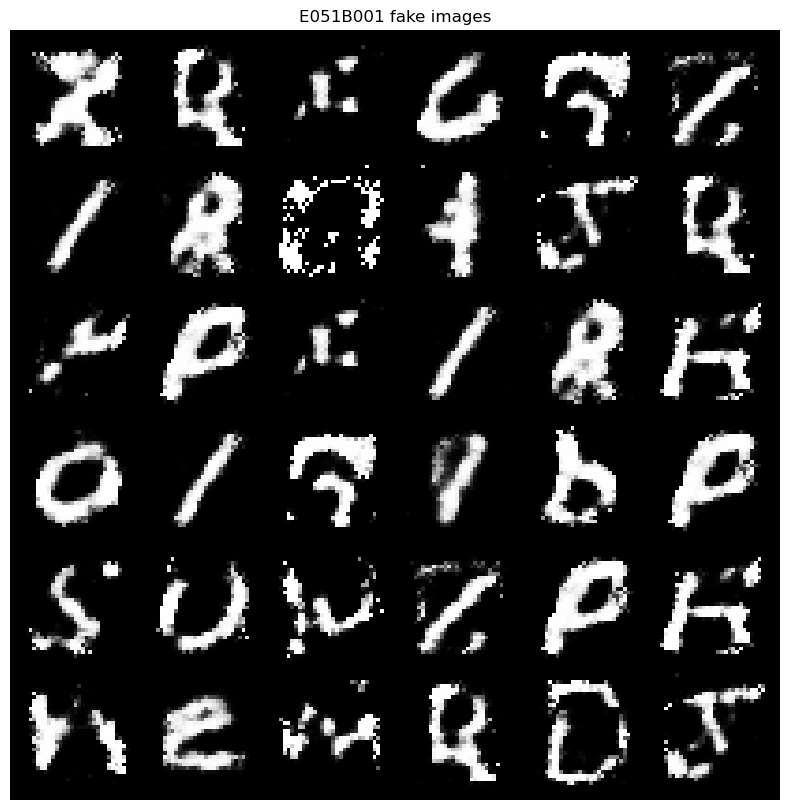

 E051B2713, [1:36:10/3:08:35] 110.98s/epoch D_loss: 0.1461 = r0.2809 + f0.0114  G_loss: 6.32490

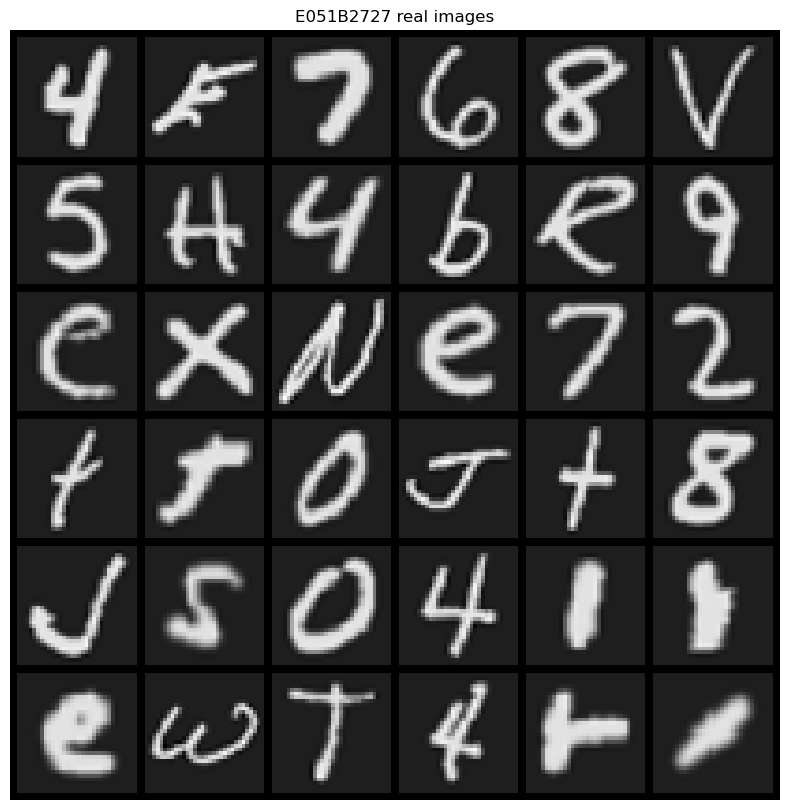

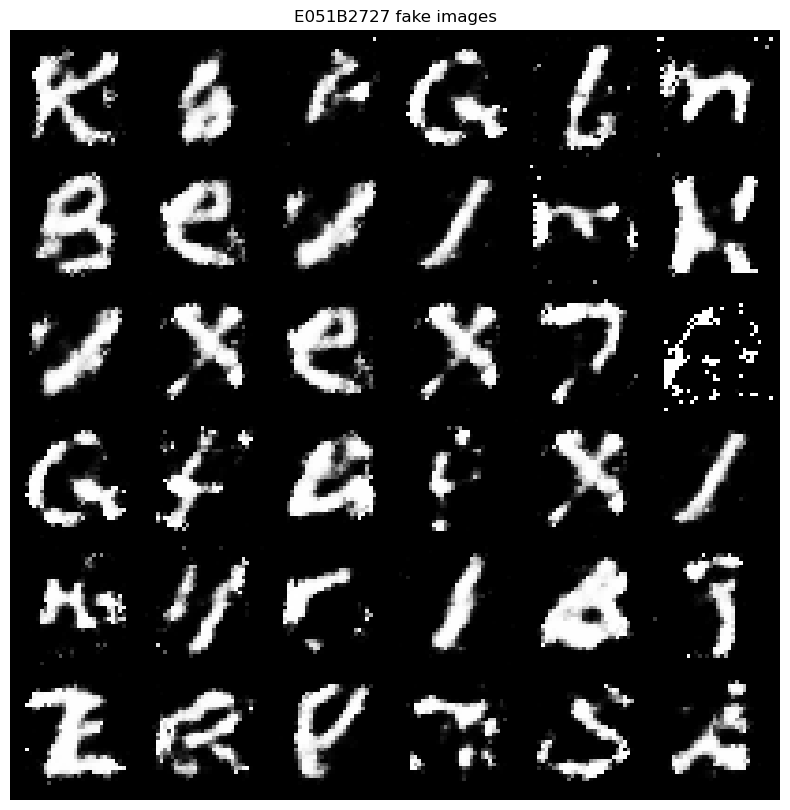

 E060B2719, [1:53:17/3:08:50] 111.45s/epoch D_loss: 0.1304 = r0.1707 + f0.0901  G_loss: 3.478360

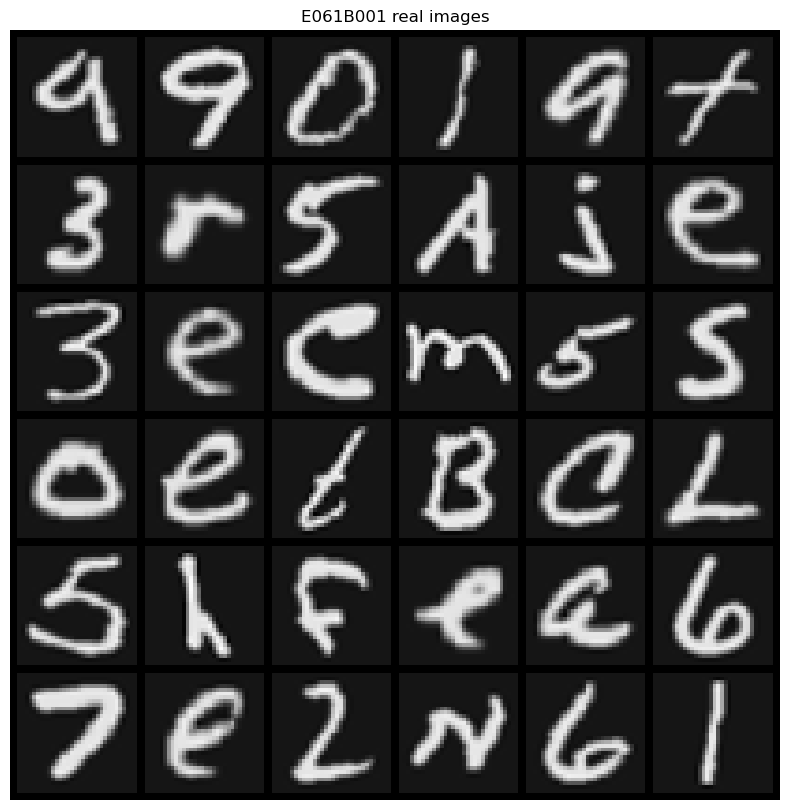

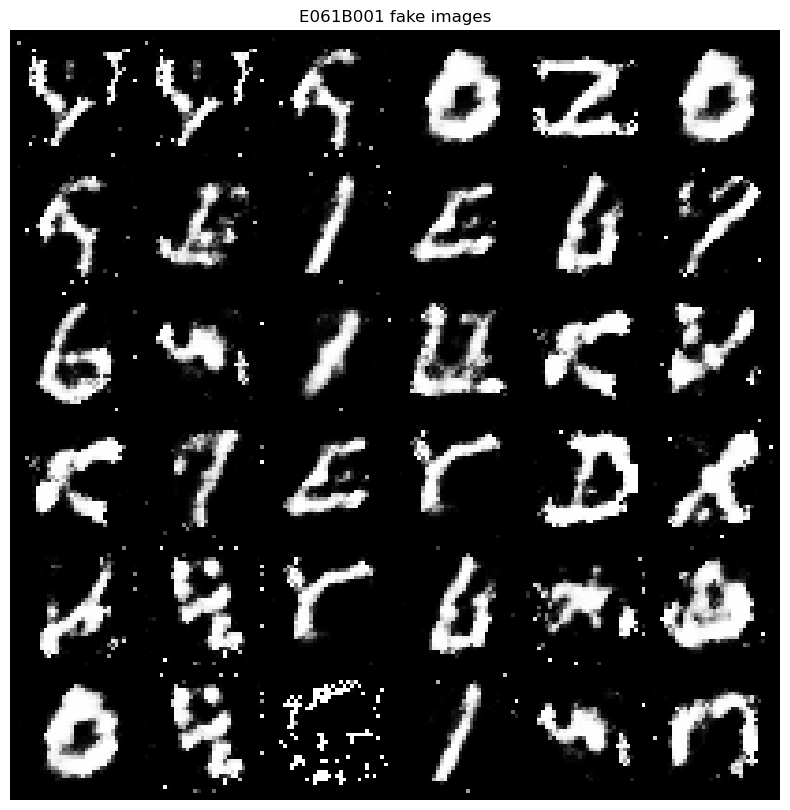

 E061B2722, [1:55:11/3:08:51] 111.48s/epoch D_loss: 0.1068 = r0.1105 + f0.1032  G_loss: 3.9520

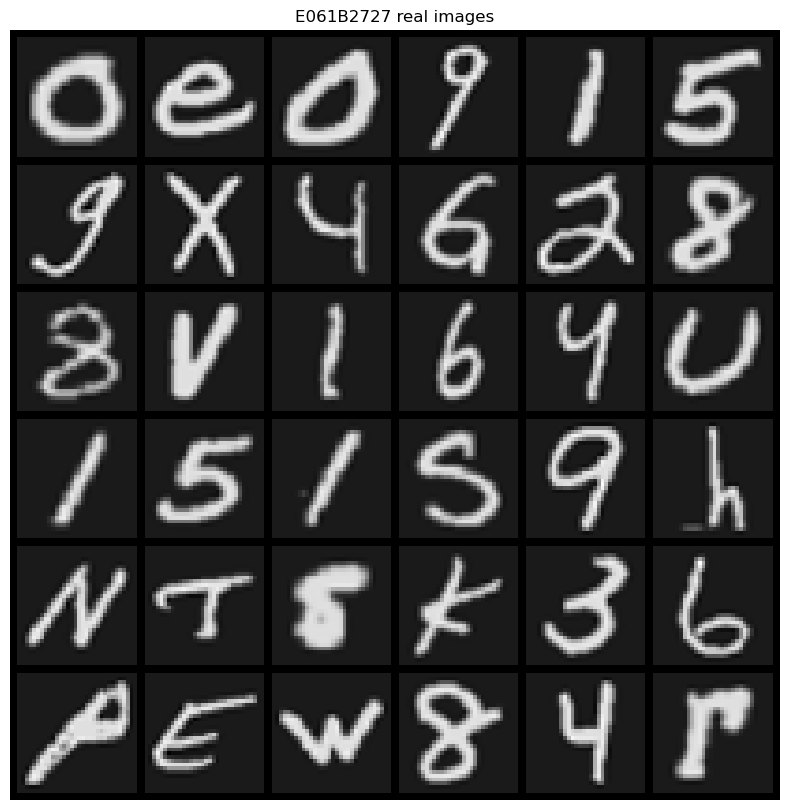

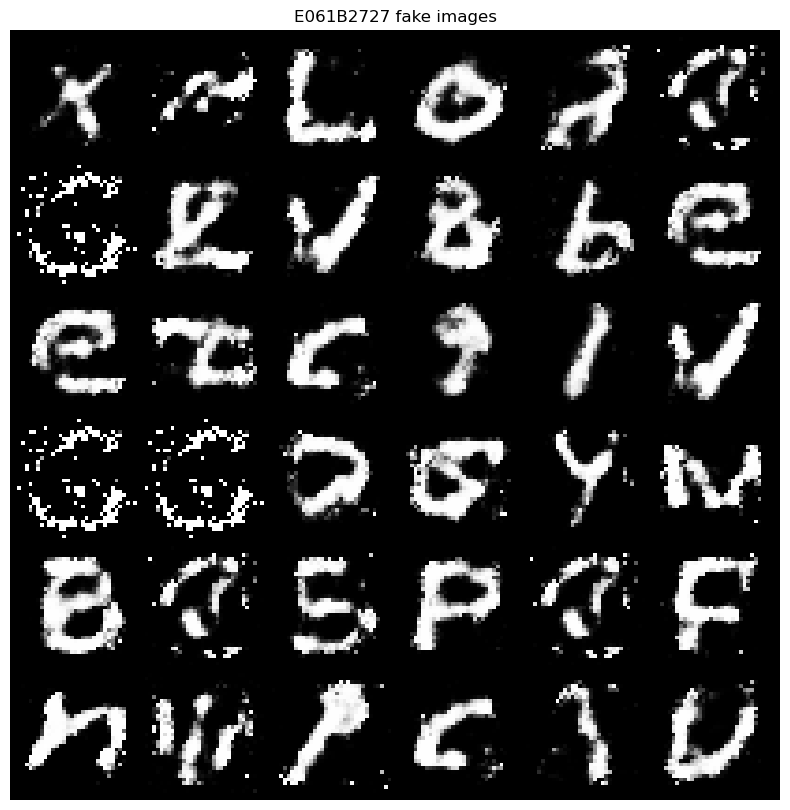

 E071B001, [2:12:02/3:08:38] 111.59s/epoch D_loss: 0.0893 = r0.0365 + f0.1421  G_loss: 4.5801108

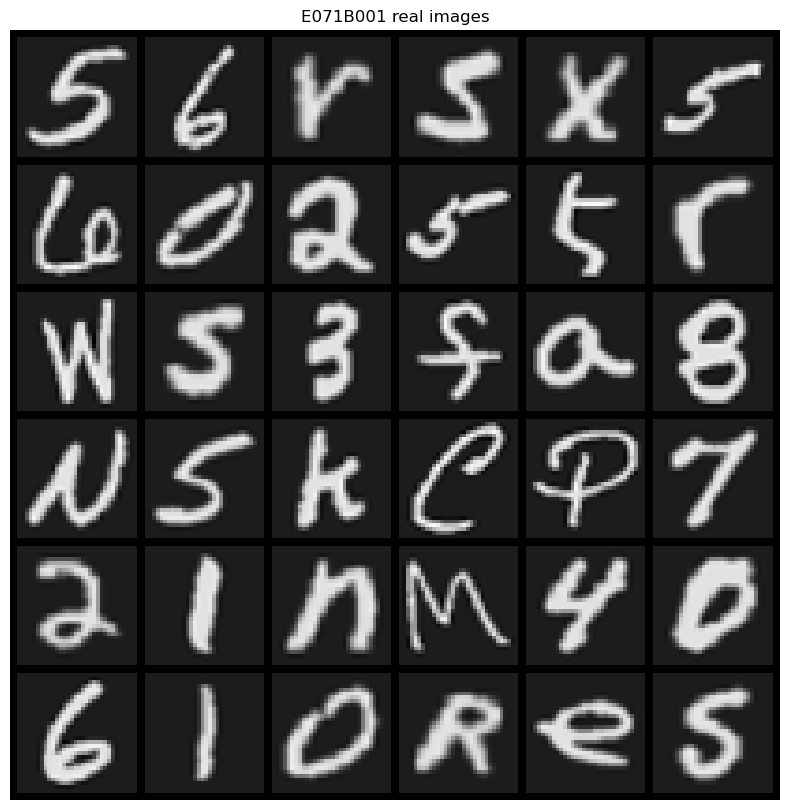

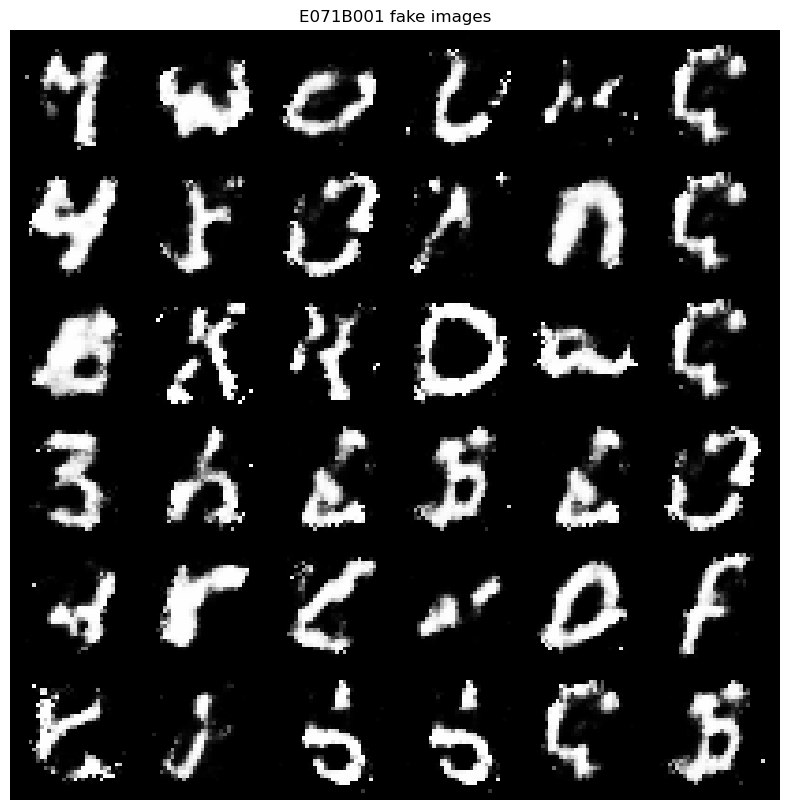

 E071B2710, [2:13:54/3:08:36] 111.60s/epoch D_loss: 0.1919 = r0.2922 + f0.0915  G_loss: 4.488602

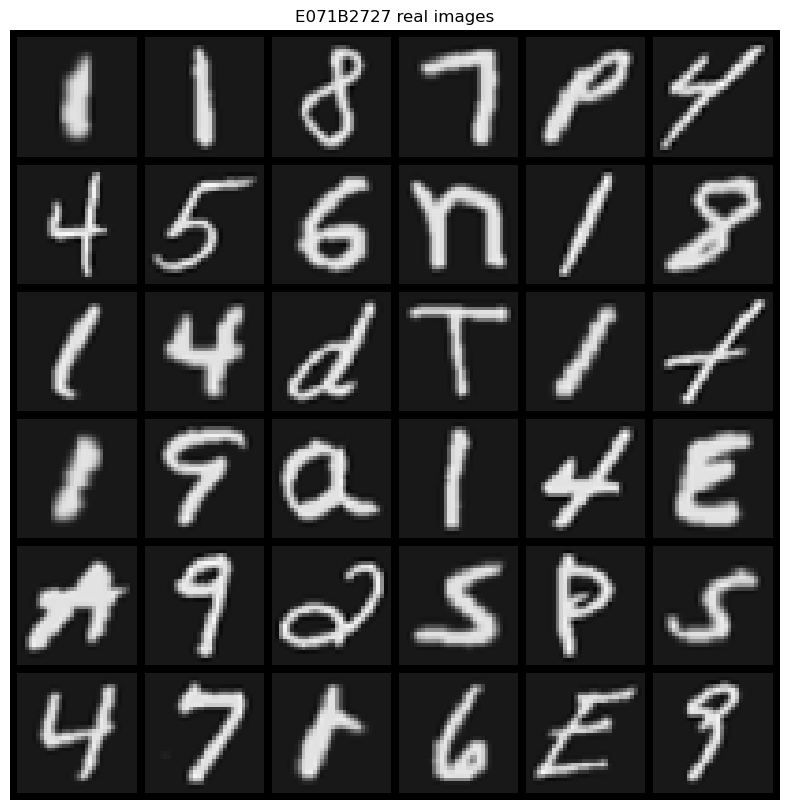

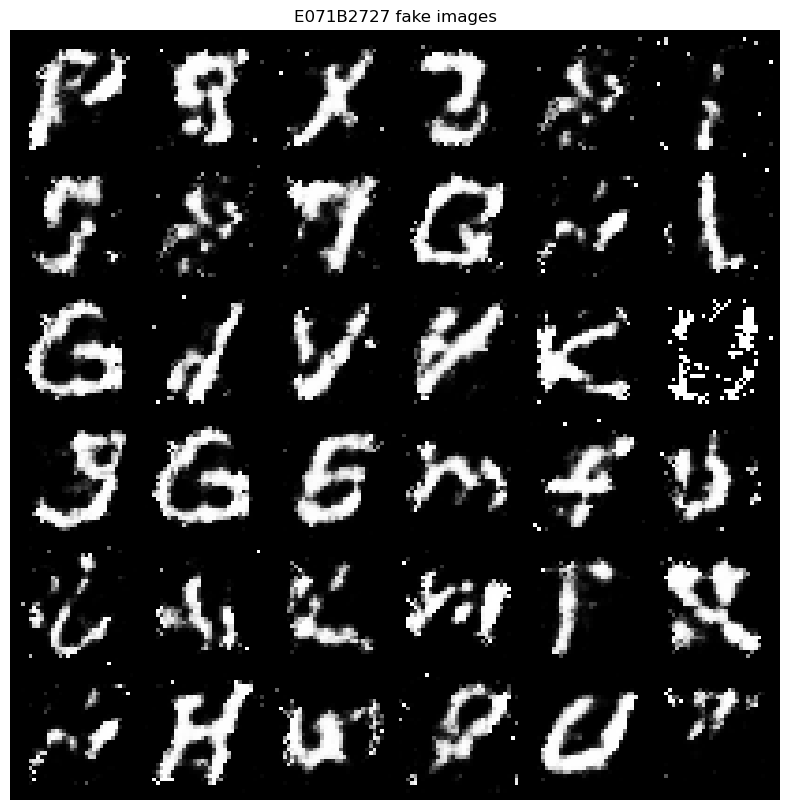

 E080B2716, [2:30:43/3:08:24] 111.65s/epoch D_loss: 0.1009 = r0.0811 + f0.1207  G_loss: 4.61517

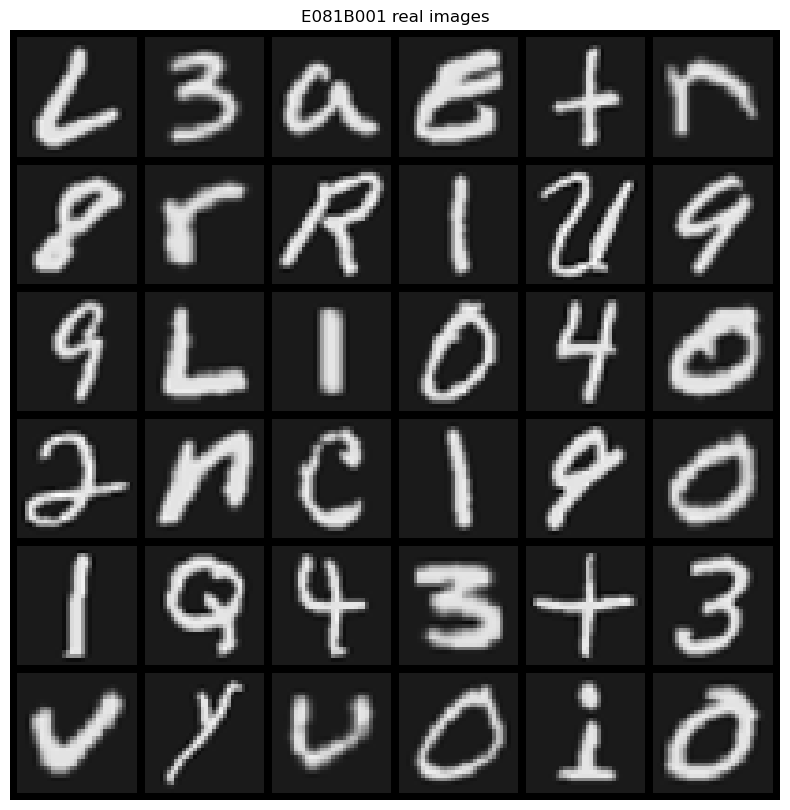

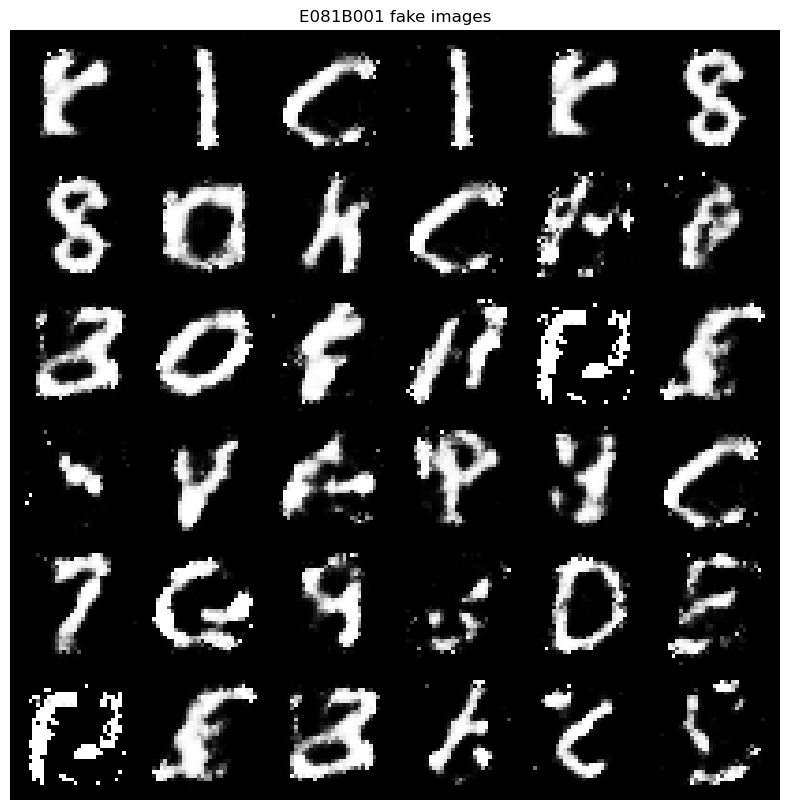

 E081B2719, [2:32:35/3:08:23] 111.66s/epoch D_loss: 0.1230 = r0.1494 + f0.0967  G_loss: 4.362851

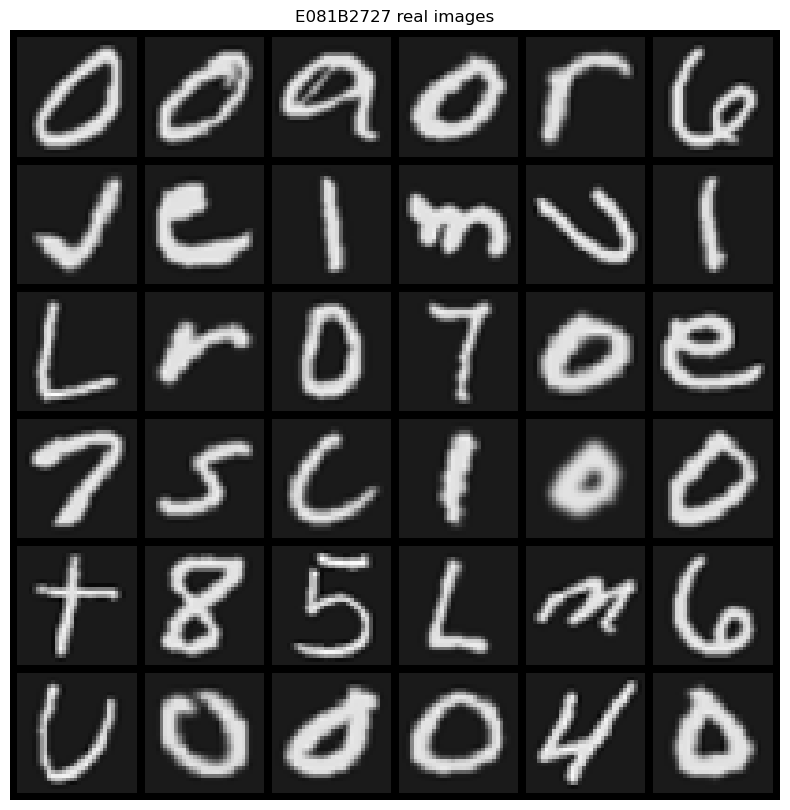

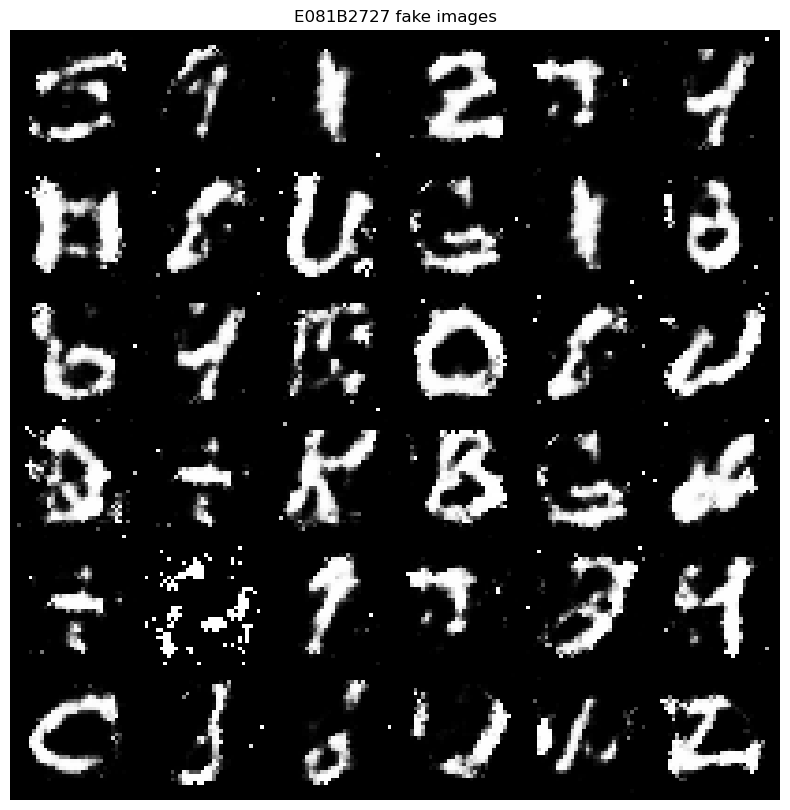

 E090B2725, [2:49:24/3:08:14] 111.70s/epoch D_loss: 0.1180 = r0.1051 + f0.1309  G_loss: 3.2408372

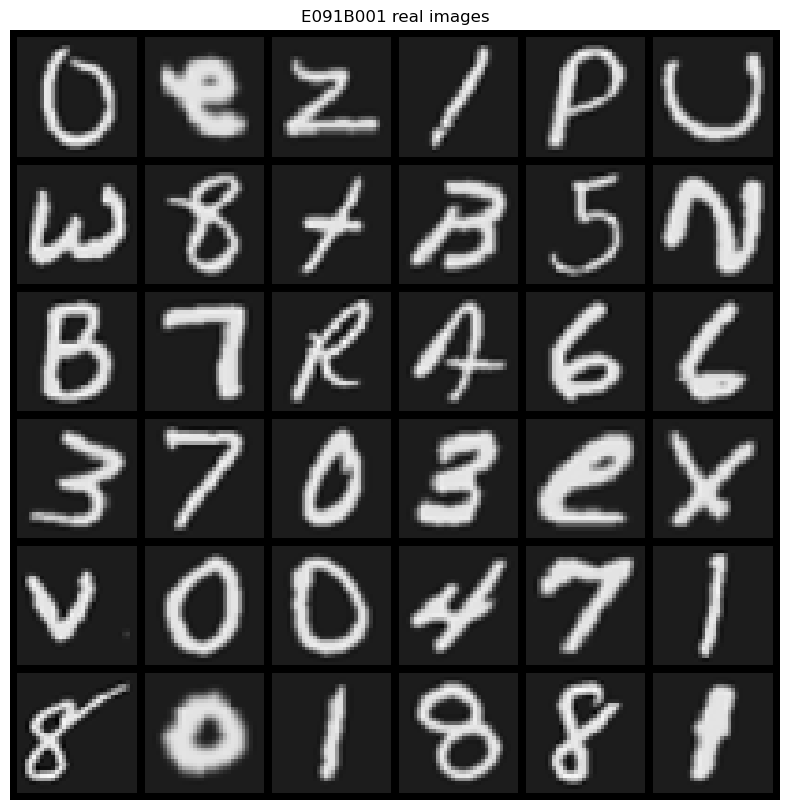

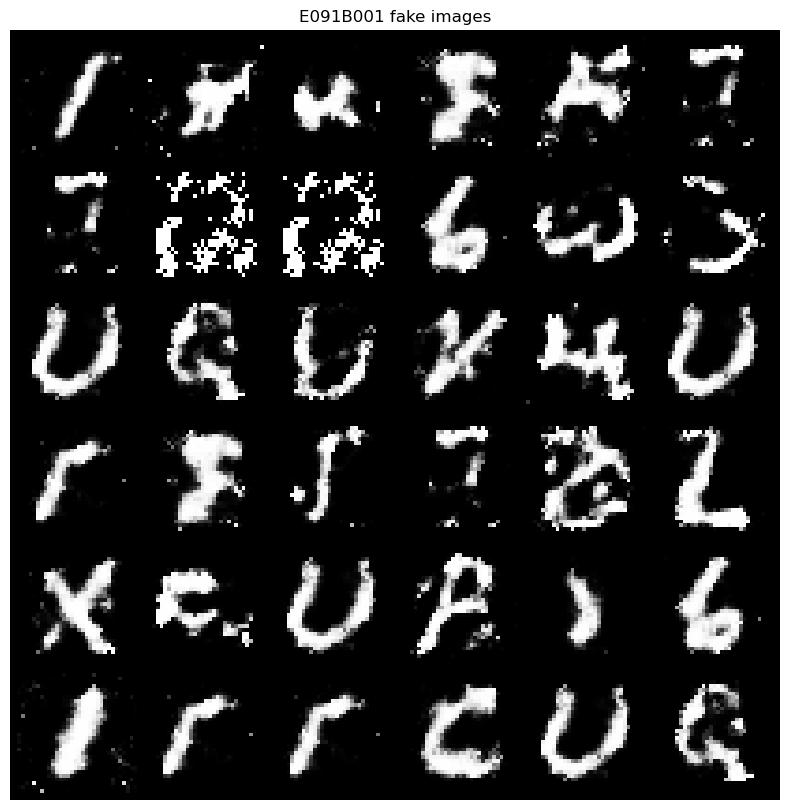

 E091B2707, [2:51:18/3:08:15] 111.73s/epoch D_loss: 0.0883 = r0.1072 + f0.0694  G_loss: 3.999200

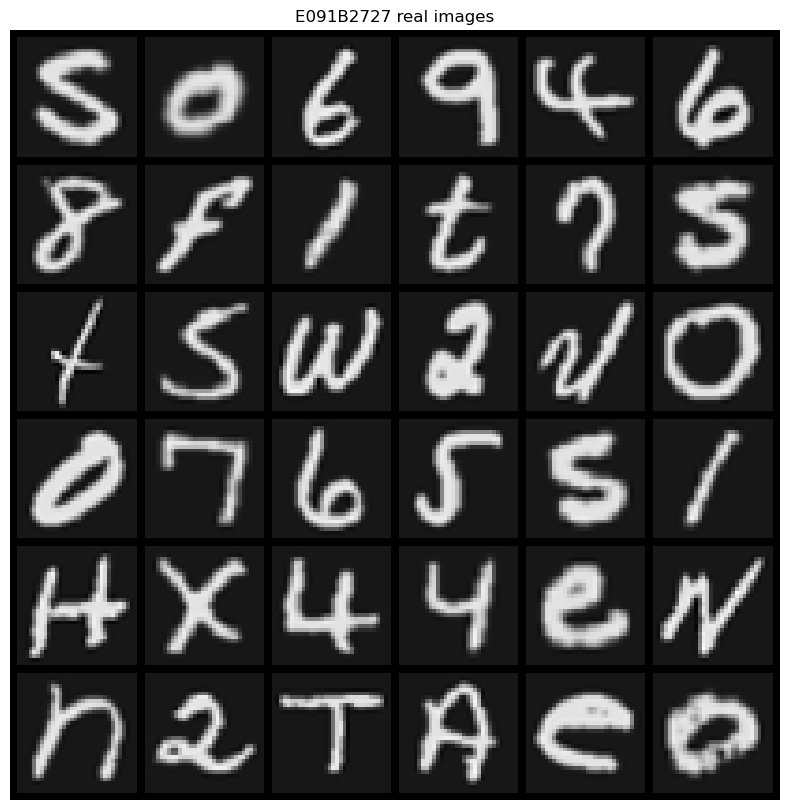

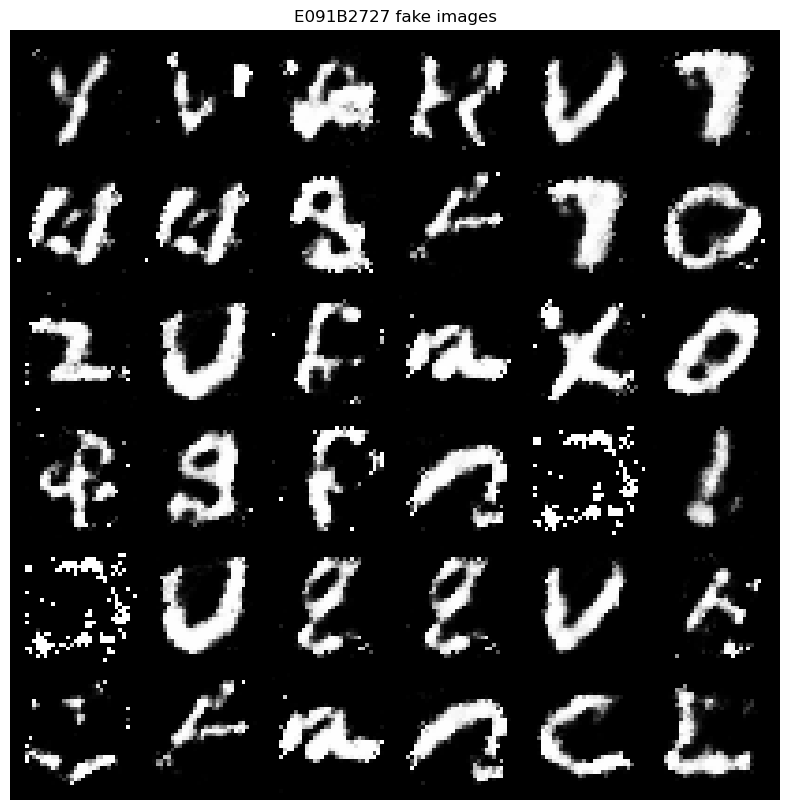

 E100B2713, [3:08:17/3:08:18] 111.86s/epoch D_loss: 0.0526 = r0.0744 + f0.0308  G_loss: 5.769110

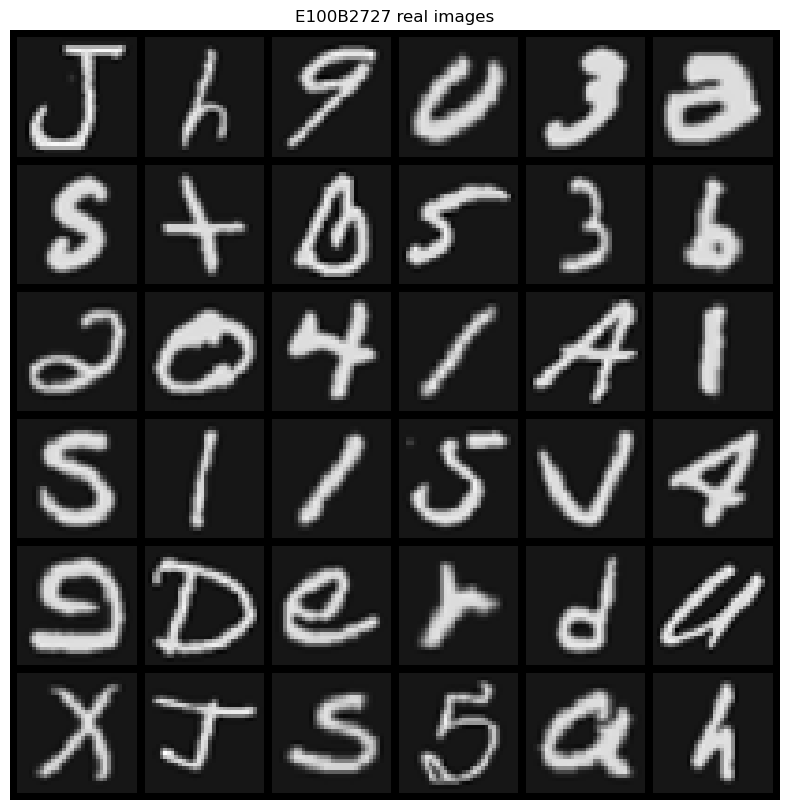

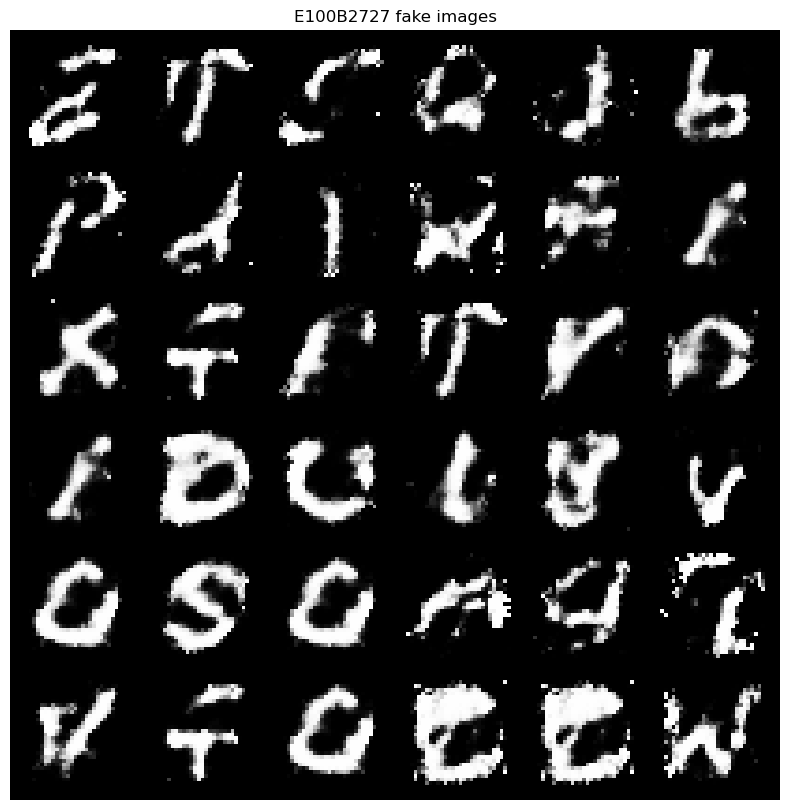

In [11]:
from torch.autograd import Variable
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

#  Training
result_path = './gan_CGan_3'
training_start = time.time()
for epoch in range(opt.n_epochs):
    loss_d_e = 0
    loss_g_e = 0
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.long().to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(imgs.size(0), opt.latent_dim).to(device)
        gen_labels = torch.from_numpy(np.random.randint(0, opt.n_classes, batch_size)).long().to(device)
        # Generate a batch of images
        fake_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(fake_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(fake_imgs.detach(), gen_labels)
        fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()


        loss_d_e += d_loss.item()
        loss_g_e += g_loss.item()
        batches_done = epoch * len(dataloader) + i

        if batches_done % (opt.sample_interval // 100 + 1) == 0:
            diff = time.time() - training_start
            a_td = to_td(diff)
            al_td = to_td(diff * opt.n_epochs * len(dataloader) / (epoch * len(dataloader) + i + 1))
            per_df = diff / (epoch + 1 + i / len(dataloader))

            print(f"\r E{epoch+1:03}B{i+1:03}, [{a_td}/{al_td}] {per_df:5.2f}s/epoch",
                  f"D_loss: {d_loss.item():6.4f} = r{real_loss.item():6.4f} + f{fake_loss.item():6.4f}",
                  f" G_loss: {g_loss.item():6.4f}",
                  end="")

        if batches_done % opt.sample_interval == 0 and epoch % 5 == 0:
            if batches_done > 10:
                torch.save(generator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}G.pth")
                torch.save(discriminator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}D.pth")
        if (epoch % 10 == 0) and (i == 0 or i == len(dataloader) - 1):        
            show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
        #  final model and result
        if (epoch == opt.n_epochs - 1) and (i == len(dataloader) - 1):
            if not os.path.isdir(result_path):
                os.mkdir(result_path)
            torch.save(generator.state_dict(), result_path + "/Generator weights.pth")
            torch.save(discriminator.state_dict(), result_path + "/Discriminator weights.pth")
            show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
    record["D_loss"].append(loss_d_e / len(dataloader))
    record["G_loss"].append(loss_g_e / len(dataloader))

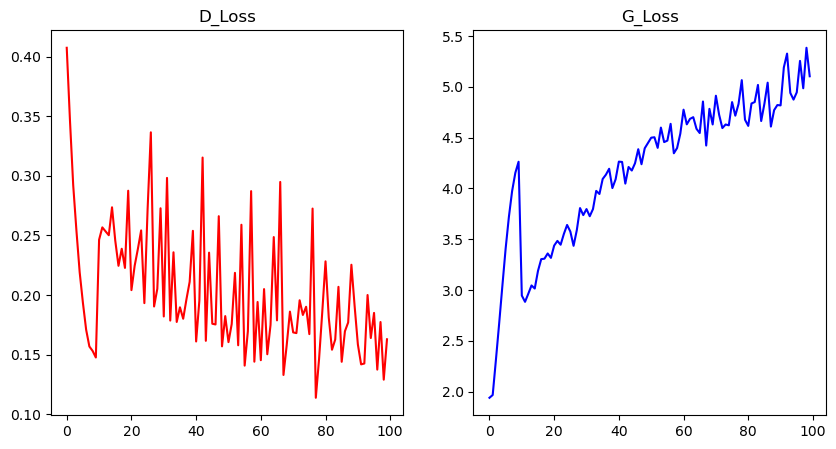

In [12]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(record["D_loss"], 'r')   # red line w ithout marker
plt.title('D_Loss')
plt.subplot(122)
plt.plot( record["G_loss"], 'b') # blue solid line with filled circle marker
plt.title('G_Loss')
plt.savefig('CGan_Loss.png')
plt.show()

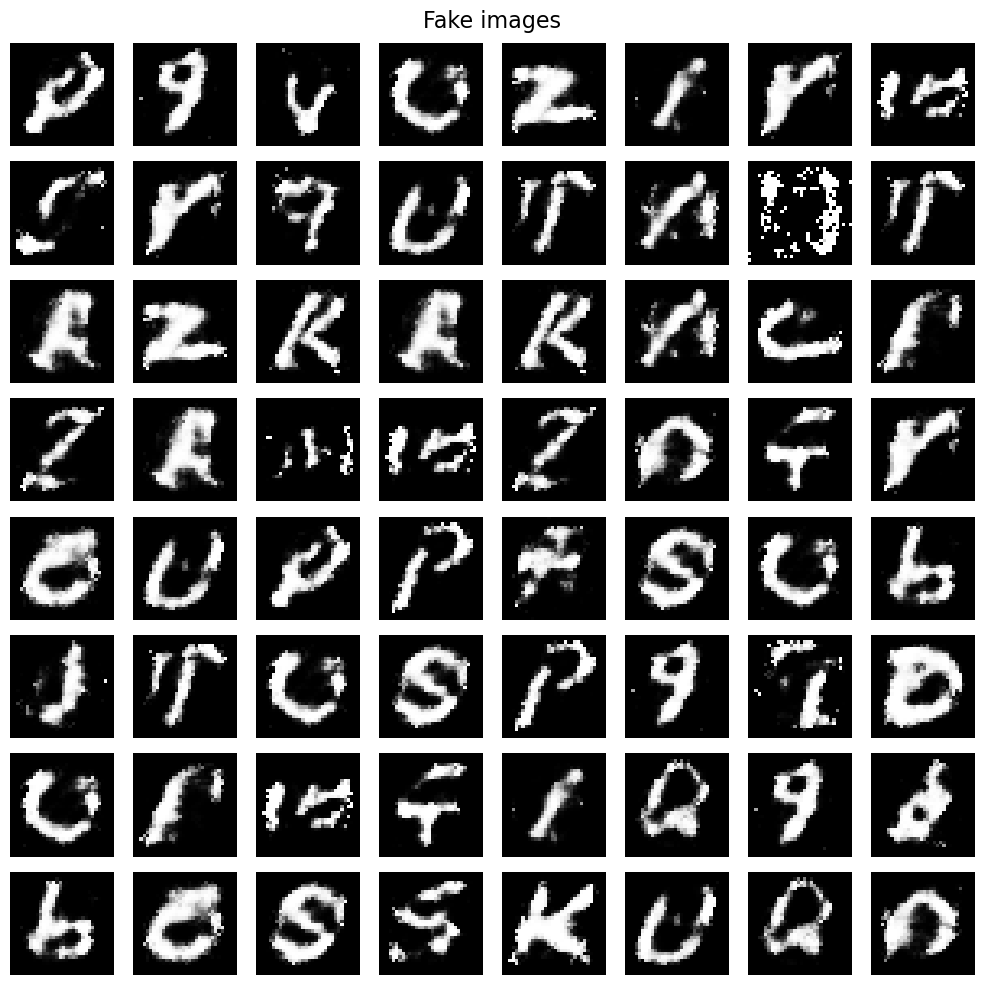

In [16]:
generator = Generator()

generator.load_state_dict(torch.load(result_path + "/Generator weights.pth"))
generator.eval()
z = torch.randn(opt.batch_size, opt.latent_dim)
gen_labels = torch.from_numpy(np.random.randint(0, opt.n_classes, opt.batch_size)).long()
fake_imgs = generator(z, gen_labels)
fake_imgs.shape

fake_imgs = fake_imgs.view(fake_imgs.size(0), opt.channels, opt.img_size, opt.img_size)

fig, axs = plt.subplots(8, 8, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    if i < len(fake_imgs):
        ax.imshow(fake_imgs[i].detach().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    else:
        ax.remove()
fig.suptitle('Fake images', fontsize=16)
fig.tight_layout()